In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from google.colab import files
from google.colab import drive


# Mount Google Drive
drive.mount('/content/gdrive')
# Install NLTK packages
nltk.download('punkt')
nltk.download('stopwords')


Mounted at /content/gdrive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Set directories
text_dir = "/content/gdrive/MyDrive/ts/Untitled folder"
stopwords_dir = "/content/gdrive/MyDrive/ts/StopWords-20240126T104150Z-001"
sentiment_dir = "/content/gdrive/MyDrive/ts/MasterDictionary"


In [15]:
# Read input data
input_df = pd.read_excel('/content/Input.xlsx')


In [16]:
# Function to extract text from HTML
def extract_text_from_html(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise exception for failed requests
        soup = BeautifulSoup(response.content, 'html.parser')
        text = ' '.join([p.get_text() for p in soup.find_all('p')])
        return text
    except Exception as e:
        print(f"Error occurred while processing URL: {url}")
        print(e)
        return ""

In [17]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s.]', '', text)
    return text

In [18]:

# Function to measure text characteristics
def measure_text(text):
    words = word_tokenize(text)
    num_sentences = text.count('.')
    num_words = len(words)
    syllable_count = sum(1 for word in words if len(re.findall(r'[aeiouy]+', word, re.IGNORECASE)) > 2)
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
    percentage_of_complex_words = syllable_count / num_words if num_words > 0 else 0
    fog_index = 0.4 * (avg_sentence_length + percentage_of_complex_words)
    return avg_sentence_length, percentage_of_complex_words, fog_index

In [19]:
# Function to count personal pronouns
def count_personal_pronouns(text):
    personal_pronouns = ["I", "we", "my", "ours", "us"]
    count = sum(text.lower().count(pronoun.lower()) for pronoun in personal_pronouns)
    return count

In [20]:
# Load stopwords
stop_words = set()
for filename in os.listdir(stopwords_dir):
    with open(os.path.join(stopwords_dir, filename), 'r', encoding='ISO-8859-1') as f:
        stop_words.update(set(f.read().splitlines()))


In [21]:
# Load sentiment words
positive_words = set()
negative_words = set()
for filename in os.listdir(sentiment_dir):
    with open(os.path.join(sentiment_dir, filename), 'r', encoding='ISO-8859-1') as f:
        words = f.read().splitlines()
        if 'positive' in filename:
            positive_words.update(words)
        else:
            negative_words.update(words)

In [22]:
# Process each URL
data = []
for index, row in input_df.iterrows():
    url = row['URL']
    url_id = row['URL_ID']
    try:
        text = extract_text_from_html(url)
        cleaned_text = clean_text(text)
        avg_sentence_length, percentage_of_complex_words, fog_index = measure_text(cleaned_text)
        word_count = len(cleaned_text.split())
        pp_count = count_personal_pronouns(cleaned_text)
        avg_word_length = sum(len(word) for word in cleaned_text.split()) / word_count if word_count > 0 else 0
        positive_score = sum(1 for word in cleaned_text.split() if word.lower() in positive_words)
        negative_score = sum(1 for word in cleaned_text.split() if word.lower() in negative_words)
        polarity_score = (positive_score - negative_score) / (positive_score + negative_score + 1e-6)
        subjectivity_score = (positive_score + negative_score) / (word_count + 1e-6)
        data.append([url_id, url, positive_score, negative_score, polarity_score, subjectivity_score,
                     avg_sentence_length, percentage_of_complex_words, fog_index,
                     avg_sentence_length,  # Duplicate avg_sentence_length
                     word_count, avg_word_length, pp_count])

    except Exception as e:
        print(f"Error occurred while processing URL ID: {url_id}")
        print(e)

Error occurred while processing URL: https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/
404 Client Error: Not Found for url: https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/
Error occurred while processing URL: https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/
404 Client Error: Not Found for url: https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/


In [23]:
# Create DataFrame
columns = ['URL_ID', 'URL', 'Positive_Score', 'Negative_Score', 'Polarity_Score', 'Subjectivity_Score',
           'Avg_Sentence_Length', 'Percentage_of_Complex_Words', 'Fog_Index', 'Avg_Sentence_Length_Dup',
           'Word_Count', 'Average_Word_Length', 'PP_Count']
output_df = pd.DataFrame(data, columns=columns)

# Save DataFrame to CSV
output_df.to_csv('Output_Data.csv', index=False)
files.download('Output_Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

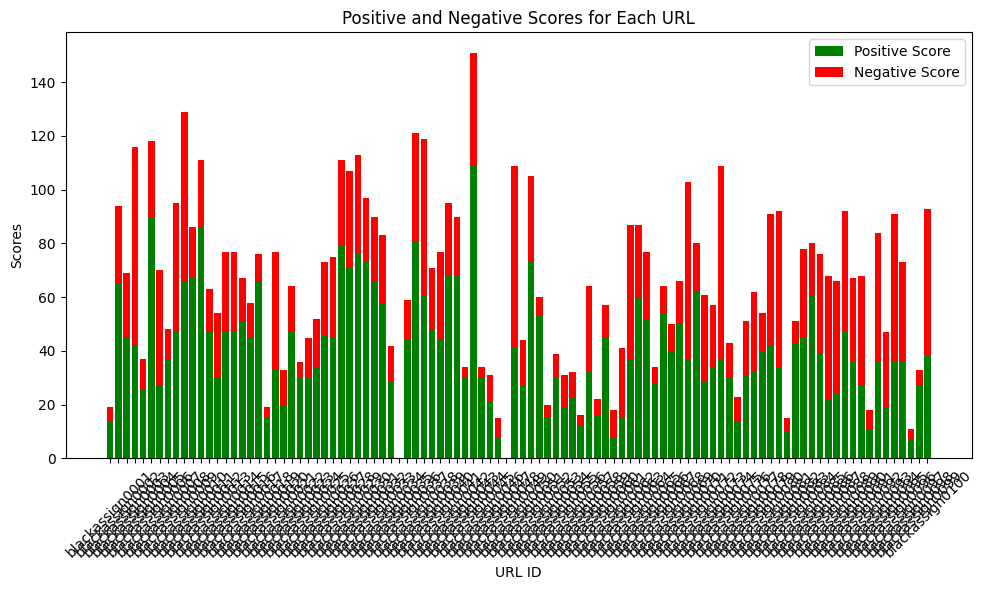

In [26]:
import matplotlib.pyplot as plt

# Plotting positive and negative scores for each URL
plt.figure(figsize=(10, 6))
plt.bar(output_df['URL_ID'], output_df['Positive_Score'], color='green', label='Positive Score')
plt.bar(output_df['URL_ID'], output_df['Negative_Score'], color='red', label='Negative Score', bottom=output_df['Positive_Score'])
plt.xlabel('URL ID')
plt.ylabel('Scores')
plt.title('Positive and Negative Scores for Each URL')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


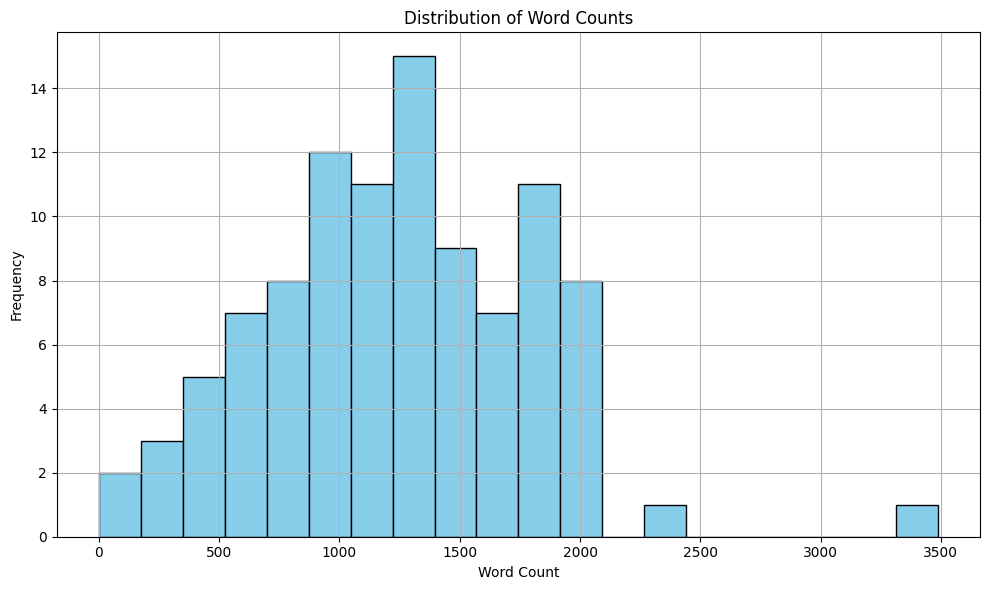

In [27]:
import matplotlib.pyplot as plt

# Plotting the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(output_df['Word_Count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.grid(True)
plt.tight_layout()
plt.show()
